In [1]:
%run ./imports_models.py
%run ./dataset_preparation_v2.ipynb
%run -i ./utils.py

Stored 'df_complete' (DataFrame)
Stored 'df_grouped_dates' (DataFrame)
Stored 'series_grouped_dates' (Series)
Stored 'pandas_dataframe_groupby_site' (DataFrameGroupBy)
Stored 'sites_names' (list)


In [2]:
PATH_SERIALIZER = './../serialized_files/'
PATH = '../../BDForecasting_V2/'
PATH_IMG = './images/'

# Data per site

In [3]:
%store -r df_grouped_dates
%store -r series_grouped_dates
%store -r pandas_dataframe_groupby_site
%store -r sites_names

# Prepare Timeseries, Train and Forecast by group

* If all_sites is <strong>False</strong>, just one model will be trained with the specific group selected in site_index. 
* If all_sites is <strong>True</strong>, multiple models will be trained for all groups in dataset.

In [4]:
all_sites = False
site_index = 47
sites = []

if all_sites:
    sites = sites_names
else:
    sites = [sites_names[site_index]]

In [5]:
groups_info = {'timeseries':[],
               'tuning_results':[],
               'models':[],
               'cross_validation_results':[],
               'forecasts':[],
               'scaler':[]}
exec_times_info = {'tuning_exec_times':[],
                   'training_exec_times':[],
                   'cross_validation_exec_times':[],
                   'forecast_exec_times':[]}
overall_exec_time = []

In [363]:
# import pickle
# pickle.dump([groups_info, exec_times_info],open('aon_group_times_info.pkl','wb'))

In [6]:
cut_final = -1 #3 anio
nrows = 0 #to be update
initial = '{} hours'.format(23*30*6)
horizon = '{} hours'.format(23*30*8)

In [7]:
if all_sites:
    print('Trainig and forecasting multiple time series groups...\n')
else:
    print('Training and forecasting %s ...\n'%sites_names[site_index])

start_time_overall = time.time()
for site in tqdm(sites):
    print('\033[1m' + 'Group %s'%(site) + '\033[0m')
    site_complete_data = pandas_dataframe_groupby_site.get_group(site)
    prepared_df = prepare_timeserie_df(site_complete_data)
    scaler = prepared_df[1]
    site_df_grouped_dates = prepared_df[0]
    site_df_grouped_dates = site_df_grouped_dates[:cut_final]
    nrows_data = site_df_grouped_dates.shape[0]
    nrows = nrows_data
    site_df_data_train = site_df_grouped_dates[:int(nrows_data*0.7)]
    site_df_data_test = site_df_grouped_dates[int(nrows_data*0.7):]
    
    
    print('Tuning...')
    start_time_tuning = time.time()
#     site_tuning_results = hyperparameter_tuning(
#                                 site_df_data_train, 
#                                 site, 
#                                 initial=initial, 
#                                 horizon=horizon
#                           )
    tuning_exec_time = time.time() - start_time_tuning
    print("--- Tuning ended at %s seconds ---" % (tuning_exec_time))
    
    
    print('Training model...')
    start_time_training = time.time()
    prophet_instance = Prophet(yearly_seasonality=True, 
                               weekly_seasonality=True,
                               seasonality_prior_scale=0.1,
                               changepoint_prior_scale=0.01,
                               interval_width=0.95)
    prophet_instance.add_seasonality(name='monthly', 
                                     period=30.5, 
                                     fourier_order=5, 
                                     prior_scale=0.02)

    prophet_instance.fit(site_df_data_train)
    training_exec_time = time.time() - start_time_training
    print("--- Training ended at %s seconds ---" % (training_exec_time))
    
    
    print('Cross validation...')
    start_time_cross_validation = time.time()
    site_cross_validation_results = cross_validation(prophet_instance, 
                                                     initial = initial, 
                                                     horizon=horizon)
    cross_validation_exec_time = time.time() - start_time_cross_validation
    print("--- Cross validation ended at %s seconds ---" % (cross_validation_exec_time))
    
    
    print('Forecasting...')
    start_time_forecast = time.time()
    site_forecast = prophet_instance.predict(site_df_data_test)
    forecast_exec_time = time.time() - start_time_forecast
    print("--- Forecast ended at %s seconds ---\n" % (forecast_exec_time))
    
    
    exec_times_info['tuning_exec_times'].append(tuning_exec_time)
    exec_times_info['training_exec_times'].append(training_exec_time)
    exec_times_info['cross_validation_exec_times'].append(cross_validation_exec_time)
    exec_times_info['forecast_exec_times'].append(forecast_exec_time)
    
    groups_info['timeseries'].append(site_df_grouped_dates)
    groups_info['tuning_results'].append(0)
    groups_info['models'].append(prophet_instance)
    groups_info['cross_validation_results'].append(site_cross_validation_results)
    groups_info['forecasts'].append(site_forecast)
    groups_info['scaler'].append(scaler)
    
    
overall_exec_time_site = time.time() - start_time_overall
overall_exec_time.append(overall_exec_time_site)
print("Multiple Training and Forecasting ended at--- %s seconds ---" % (overall_exec_time_site))

Training and forecasting S&C-AEB: CB&WD&A-PU-DE ...



  0%|          | 0/1 [00:00<?, ?it/s]

Group S&C-AEB: CB&WD&A-PU-DE
Tuning...
--- Tuning ended at 0.0 seconds ---
Training model...


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2018-07-12 03:00:00 and 2019-06-22 03:00:00


--- Training ended at 20.84641981124878 seconds ---
Cross validation...


  0%|          | 0/4 [00:00<?, ?it/s]

--- Cross validation ended at 34.228971004486084 seconds ---
Forecasting...
--- Forecast ended at 5.636926174163818 seconds ---

Multiple Training and Forecasting ended at--- 60.79506826400757 seconds ---


# Execution times info

Times for each group (unit: segs)

In [8]:
exec_times_info

{'tuning_exec_times': [0.0],
 'training_exec_times': [20.84641981124878],
 'cross_validation_exec_times': [34.228971004486084],
 'forecast_exec_times': [5.636926174163818]}

In [9]:
pd.DataFrame(exec_times_info)

,tuning_exec_times,training_exec_times,cross_validation_exec_times,forecast_exec_times
0,0.0,20.84642,34.228971,5.636926


In [10]:
overall_exec_time[0]

60.79506826400757

# Load group info

In [11]:
index = 0

In [30]:
# print('%s has been selected'%sites_names[site_index])
# if not all_sites:
#     site_index = 0
    
cross_validation_results = groups_info['cross_validation_results'][index]
forecast_site = groups_info['forecasts'][index]
df_data_site = groups_info['timeseries'][index]
nrows = len(df_data_site)
df_data_train_site = df_data_site[:int(nrows*0.7)]
df_data_test_site = df_data_site[int(nrows*0.7):]
y_true_scaled = df_data_test_site['y']
scaler = groups_info['scaler'][index]
prophet_instance = groups_info['models'][index]

# Revert scaling

In [13]:
y_true = scaler.inverse_transform(y_true_scaled.values.reshape(-1,1))

# Training evaluation metrics

In [14]:
cross_validation_results_no_negative = replace_negative_values_with_ceros(cross_validation_results.copy())

performance_metrics_training = get_performance_metrics_training(cross_validation_results_no_negative)
mse_mean_training_no_negative = performance_metrics_training[0]
rmse_mean_training_no_negative = performance_metrics_training[1]
mae_mean_training_no_negative = performance_metrics_training[2]

INFO:fbprophet:Skipping MAPE because y close to 0
C:\Users\59399\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median



In [15]:
training_performace_site = pd.DataFrame({'mse_mean_training':mse_mean_training_no_negative, 
                                         'rmse_mean_training':rmse_mean_training_no_negative, 
                                         'mae_mean_training':mae_mean_training_no_negative},
                                          index=[0])
training_performace_site

,mse_mean_training,rmse_mean_training,mae_mean_training
0,0.010811,0.103808,0.075592


# Forecast evaluation metrics

In [16]:
y_pred_no_negative_scaled = replace_negative_values_with_ceros(forecast_site.copy(), forecast_df=True)

## Revert scaling

In [17]:
y_pred_no_negative = scaler.inverse_transform(y_pred_no_negative_scaled.values.reshape(-1,1))

## Calculating

In [18]:
performance_metrics_forecast = get_performance_metrics_forecast(y_true, y_pred_no_negative)
mae_forecast_no_negative = performance_metrics_forecast[0]
mse_forecast_no_negative = performance_metrics_forecast[1]
rmse_forecast_no_negative = performance_metrics_forecast[2]

In [19]:
forecast_performace_site = pd.DataFrame({'mse_forecast_site':mse_forecast_no_negative, 
                                         'rmse_forecast_site':rmse_forecast_no_negative, 
                                         'mae_forecast_site':mae_forecast_no_negative},
                                          index=[0])
forecast_performace_site

,mse_forecast_site,rmse_forecast_site,mae_forecast_site
0,1.96082,1.409182,3.844813


# Plots by site

In [431]:
groups_info['timeseries'][0]

,ds,y
0,2018-01-01 01:00:00,0.05
1,2018-01-01 02:00:00,0.00
2,2018-01-01 03:00:00,0.00
3,2018-01-01 04:00:00,0.05
4,2018-01-01 05:00:00,0.05
...,...,...
25203,2020-12-31 19:00:00,0.10
25204,2020-12-31 20:00:00,0.05
25205,2020-12-31 21:00:00,0.20
25206,2020-12-31 22:00:00,0.15


In [27]:
y_pred_df_site = forecast_site[['ds','yhat']].copy()
y_pred_df_site['yhat'] = y_pred_no_negative
y_pred_df_site.index = series_grouped_dates[int(nrows*0.7)+1:].index
y_true_df_site = df_data_test_site.copy()
y_true_df_site['ds'] = pd.to_datetime(y_true_df_site['ds'])
y_true_df_site['y'] = y_true 
y_true_df_site.index = series_grouped_dates[int(nrows*0.7)+1:].index

<AxesSubplot:xlabel='DATES'>

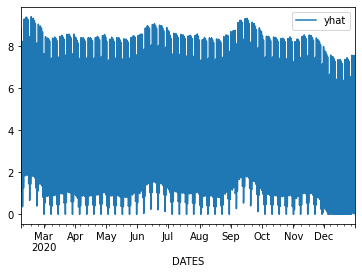

In [28]:
y_pred_df_site[['yhat']].plot()

In [76]:
forecast_site['yhat'] = y_pred_no_negative

In [80]:
forecast_site['yhat_lower'] = scaler.inverse_transform(forecast_site['yhat_lower'].values.reshape(-1,1))

In [81]:
forecast_site['yhat_upper'] = scaler.inverse_transform(forecast_site['yhat_upper'].values.reshape(-1,1))

In [34]:
# forecast_site['yhat'] = scaler.transform(forecast_site['yhat'].values.reshape(-1,1))

In [69]:
prophet_instance.history['y'] = scaler.inverse_transform(df_data_train_site['y'].values.reshape(-1,1))

In [90]:
prophet_instance.history = prophet_instance.history[23*30*12:]

In [116]:
prophet_instance2 = prophet_instance

In [117]:
prophet_instance2.history = prophet_instance2.history[23*30*3:]

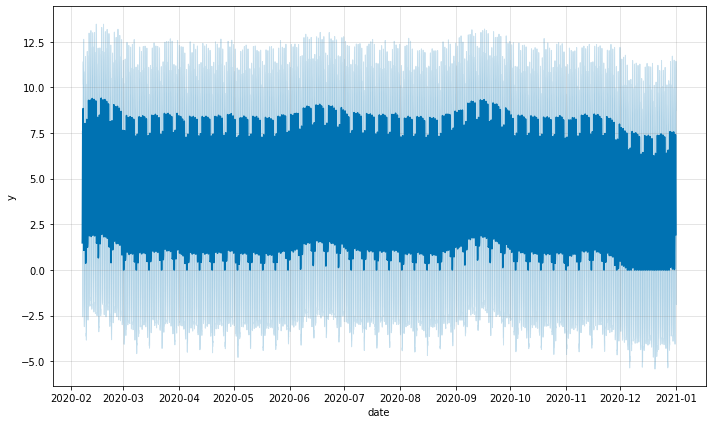

In [119]:
# prophet_instance = groups_info['models'][0]
fig_forecast = prophet_instance.plot(forecast_site, xlabel='date')
# a = add_changepoints_to_plot(fig_forecast.gca(), prophet_instance, forecast_site)
plt.savefig("{}prophet_forecast_default_g47_realvalues.png".format(PATH_IMG), format="png")

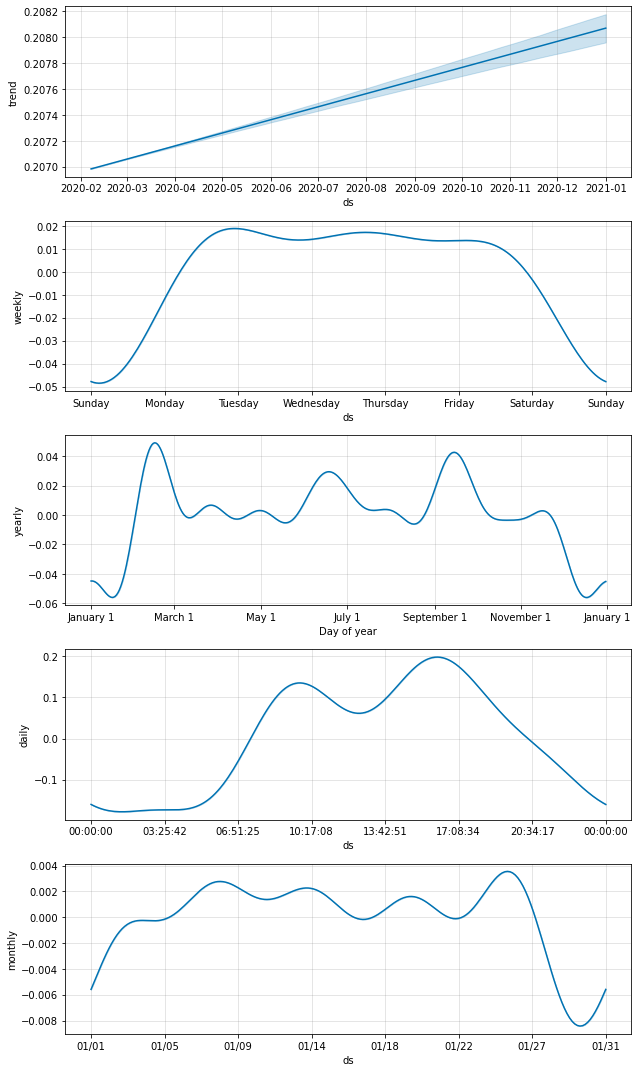

In [241]:
fig_forecast_components = prophet_instance.plot_components(forecast_site)
plt.savefig("{}prophet_forecast_components_default_g47.png".format(PATH_IMG), format="png")

### Plot per year

In [362]:
init_date = '2020-01-01'
end_date = '2020-12-31'
ax_2020=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_2020)
plt.title('Year 2020')
# plt.savefig("{}prophet_forecast_own_g47_noscaled.png".format(PATH_IMG), format="png")

KeyError: Period('2020-10-08', 'D')

### Plots per month

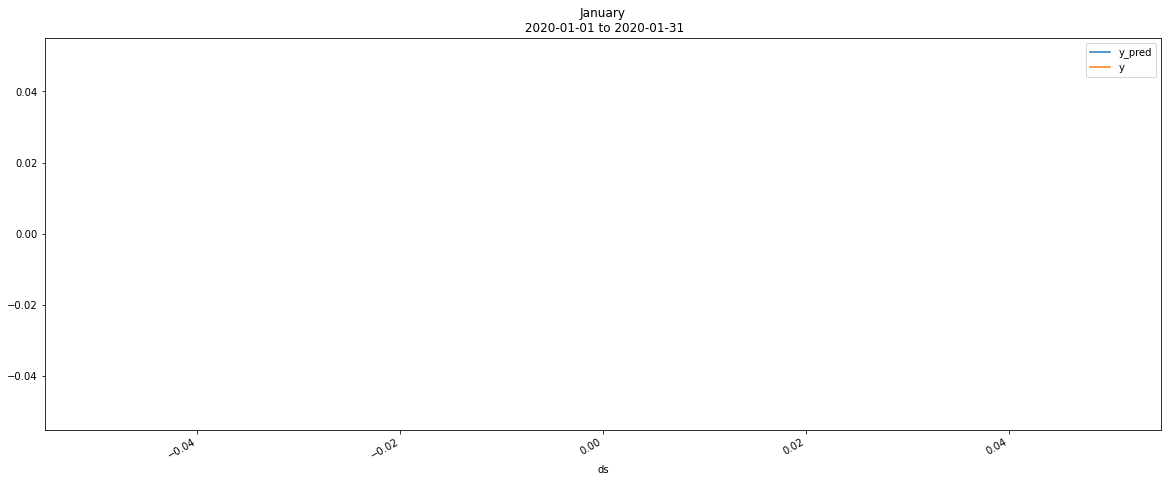

In [272]:
init_date = '2020-01-01'
end_date = '2020-01-31'
ax_jan=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_jan)
plt.title('January\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_january_g47_noscaled.png".format(PATH_IMG), format="png")

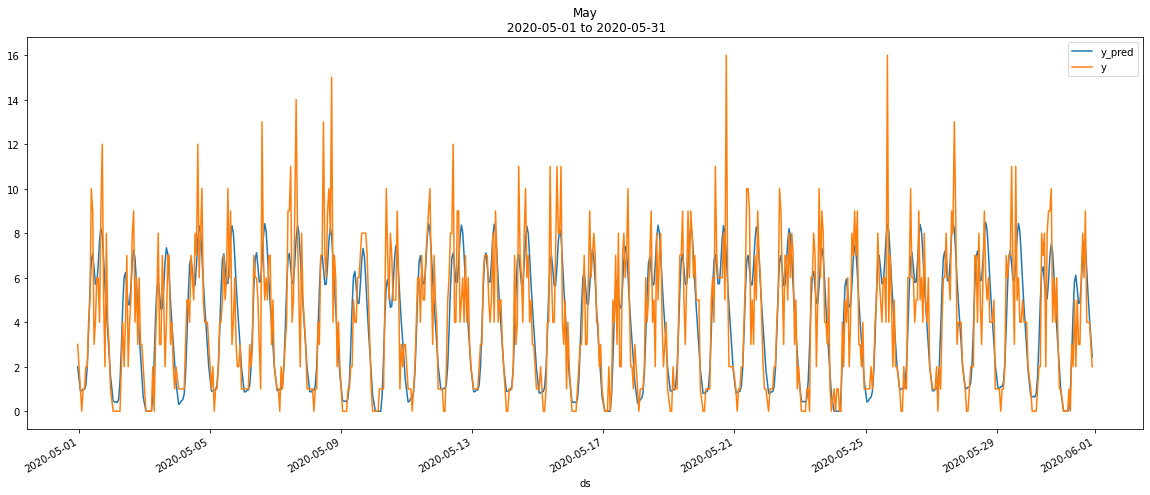

In [273]:
init_date = '2020-05-01'
end_date = '2020-05-31'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_g47_noscaled.png".format(PATH_IMG), format="png")

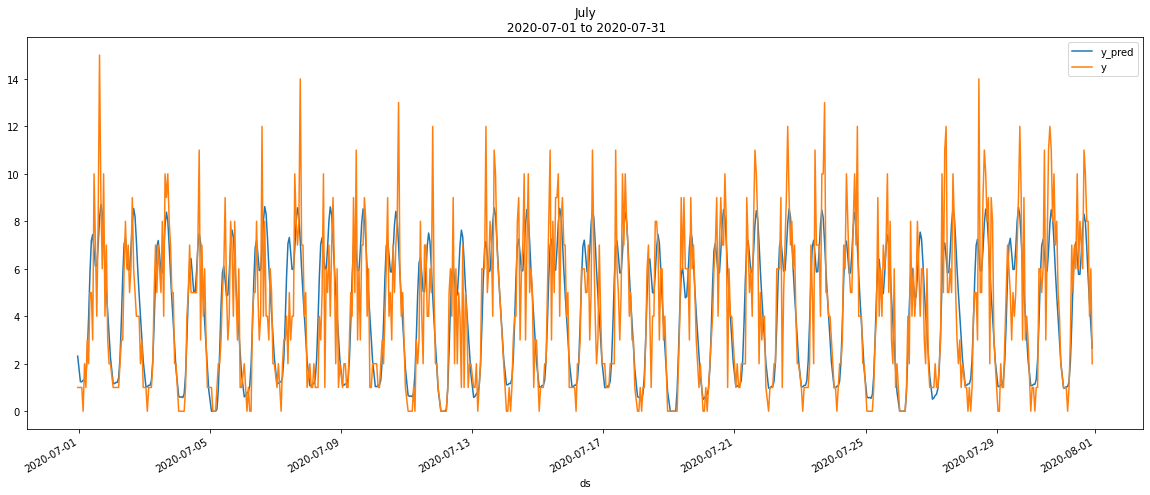

In [274]:
init_date = '2020-07-01'
end_date = '2020-07-31'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('July\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_july_g47_noscaled.png".format(PATH_IMG), format="png")

### Plots per week

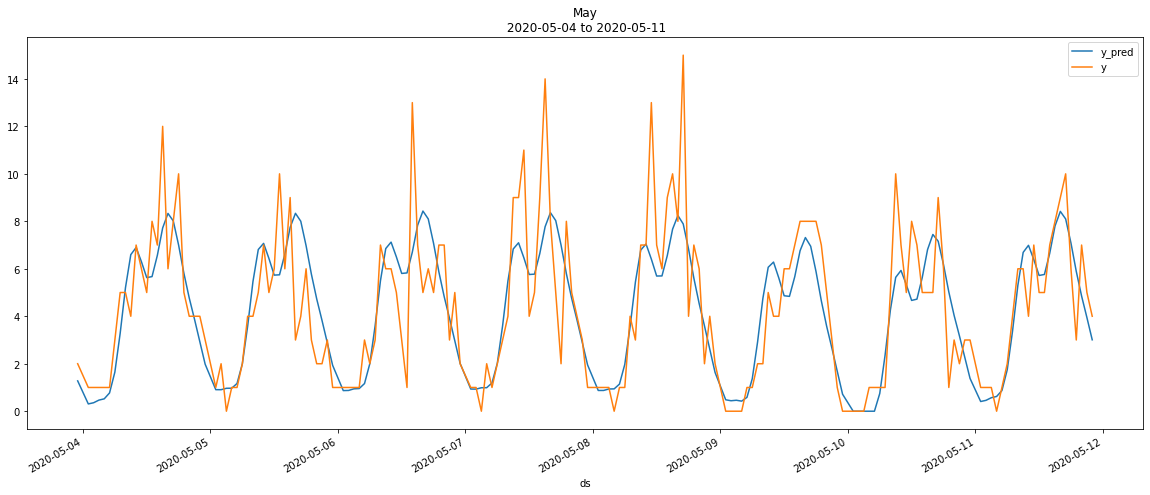

In [275]:
init_date = '2020-05-04'
end_date = '2020-05-11'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_0504_0511_g47_noscaled.png".format(PATH_IMG), format="png")

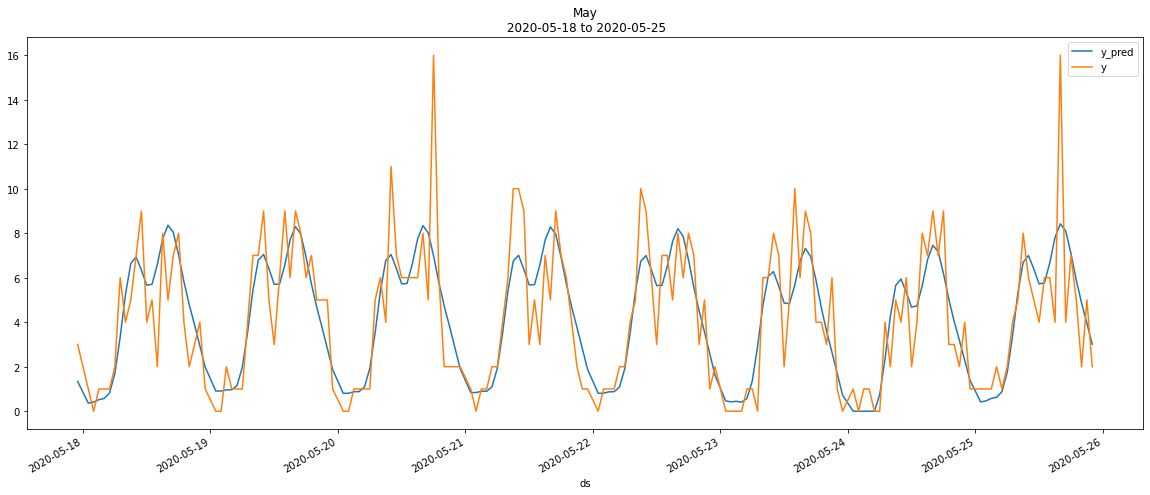

In [276]:
init_date = '2020-05-18'
end_date = '2020-05-25'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_0518_0525_g47_noscaled.png".format(PATH_IMG), format="png")

### Plots per day

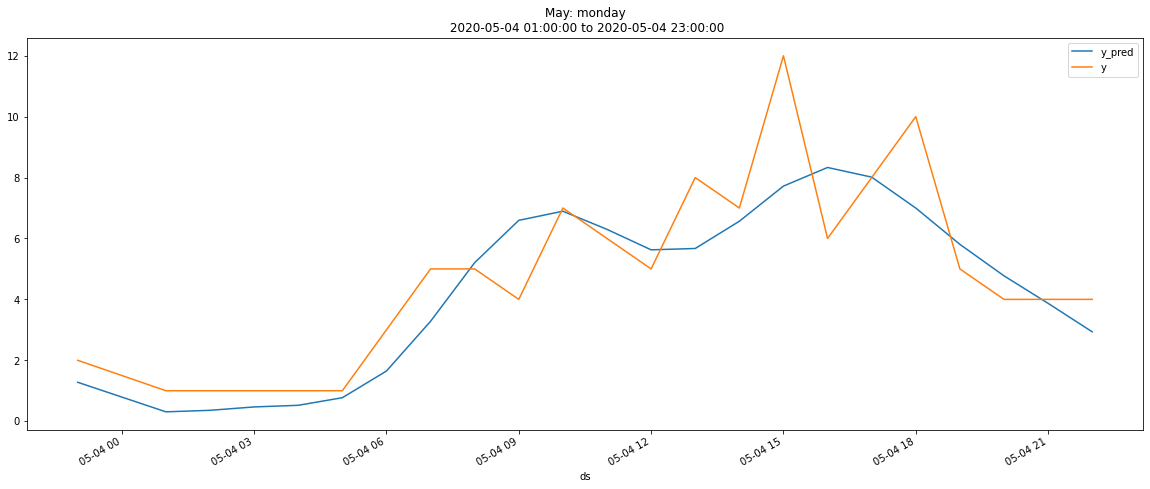

In [277]:
init_date = '2020-05-04 01:00:00'
end_date = '2020-05-04 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: monday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_monday04_g47_noscaled.png".format(PATH_IMG), format="png")

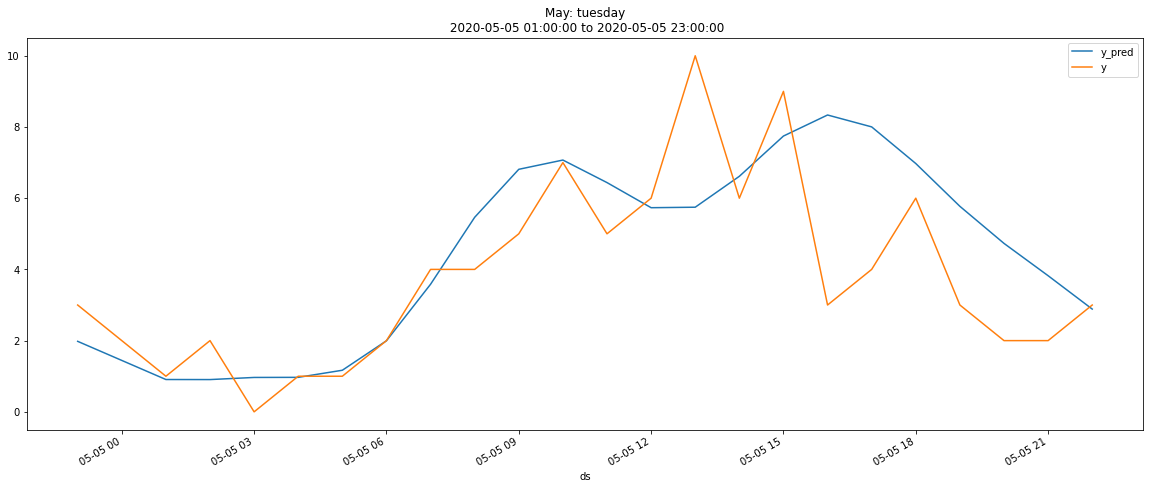

In [278]:
init_date = '2020-05-05 01:00:00'
end_date = '2020-05-05 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: tuesday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_tuesday05_g47_noscaled.png".format(PATH_IMG), format="png")

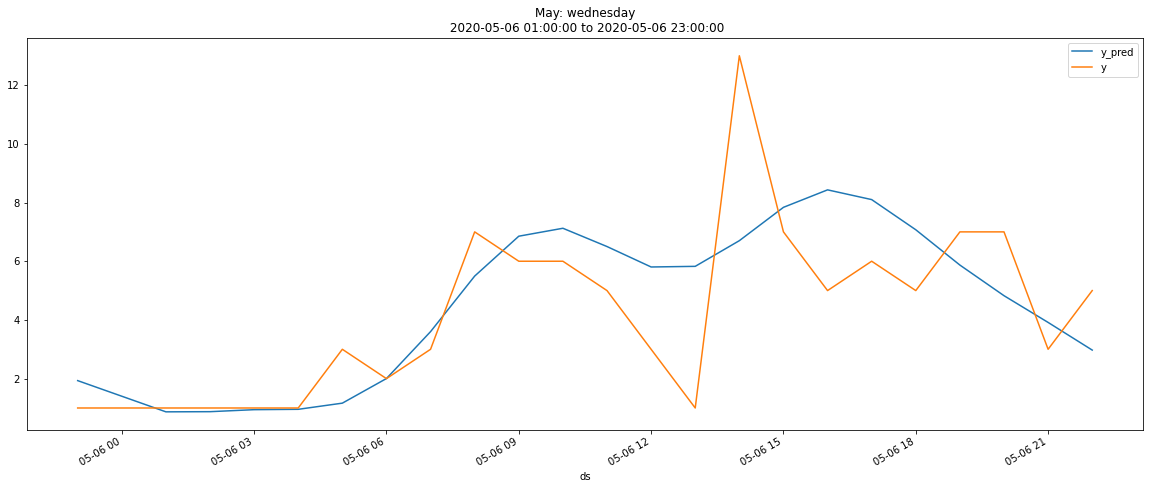

In [279]:
init_date = '2020-05-06 01:00:00'
end_date = '2020-05-06 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: wednesday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_wednesday06_g47_noscaled.png".format(PATH_IMG), format="png")

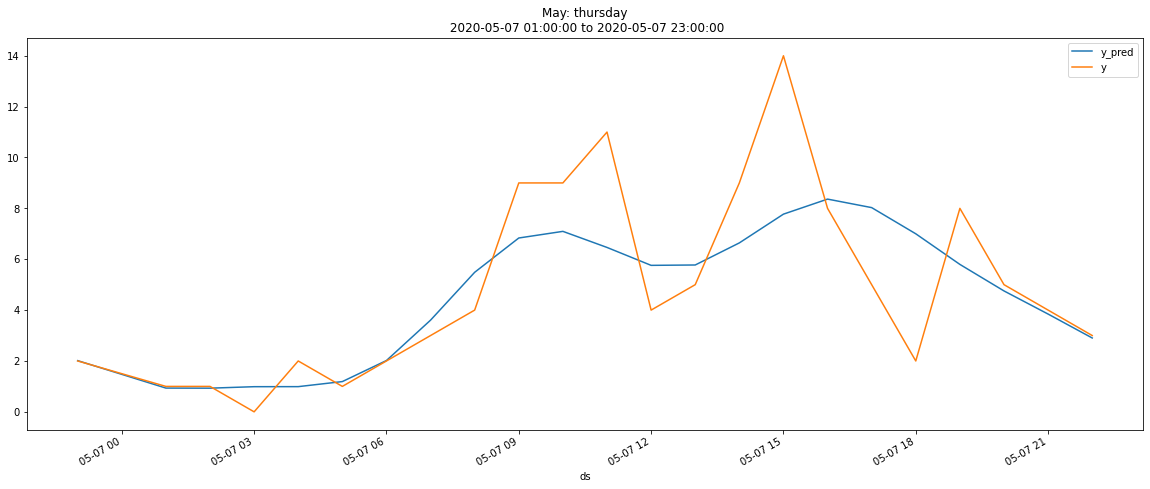

In [280]:
init_date = '2020-05-07 01:00:00'
end_date = '2020-05-07 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: thursday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_thursday07_g47_noscaled.png".format(PATH_IMG), format="png")

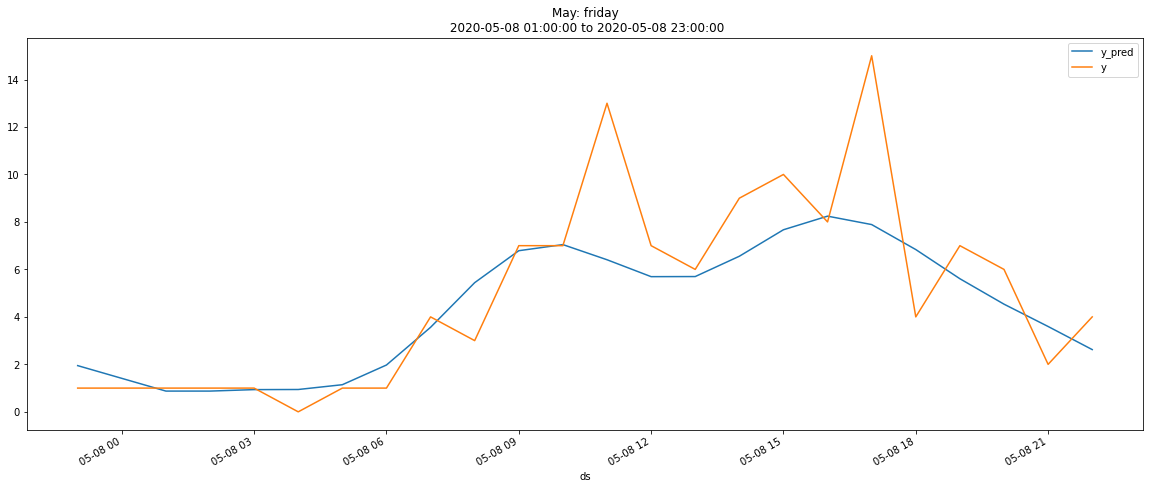

In [281]:
init_date = '2020-05-08 01:00:00'
end_date = '2020-05-08 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: friday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_friday08_g47_noscaled.png".format(PATH_IMG), format="png")

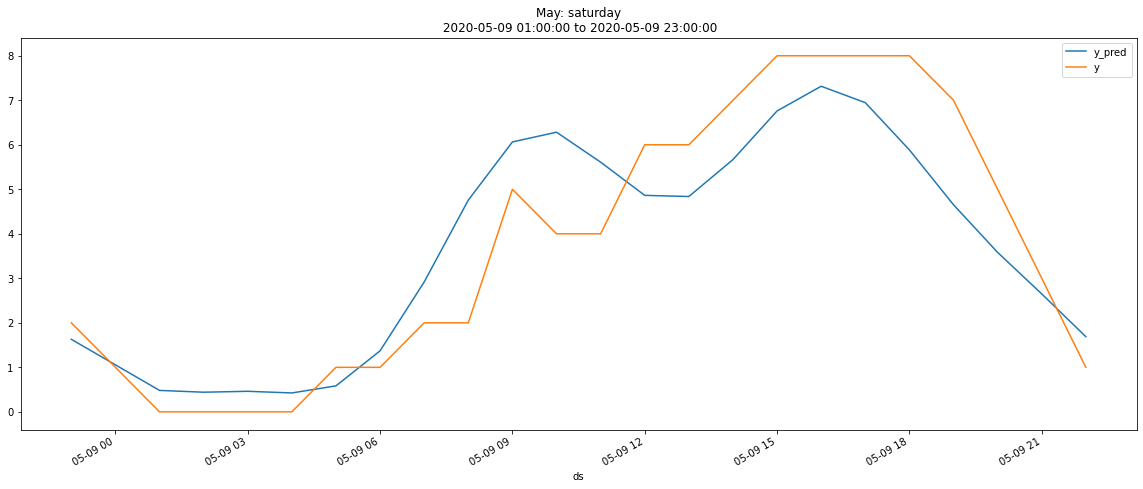

In [282]:
init_date = '2020-05-09 01:00:00'
end_date = '2020-05-09 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: saturday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_saturday09_g47_noscaled.png".format(PATH_IMG), format="png")

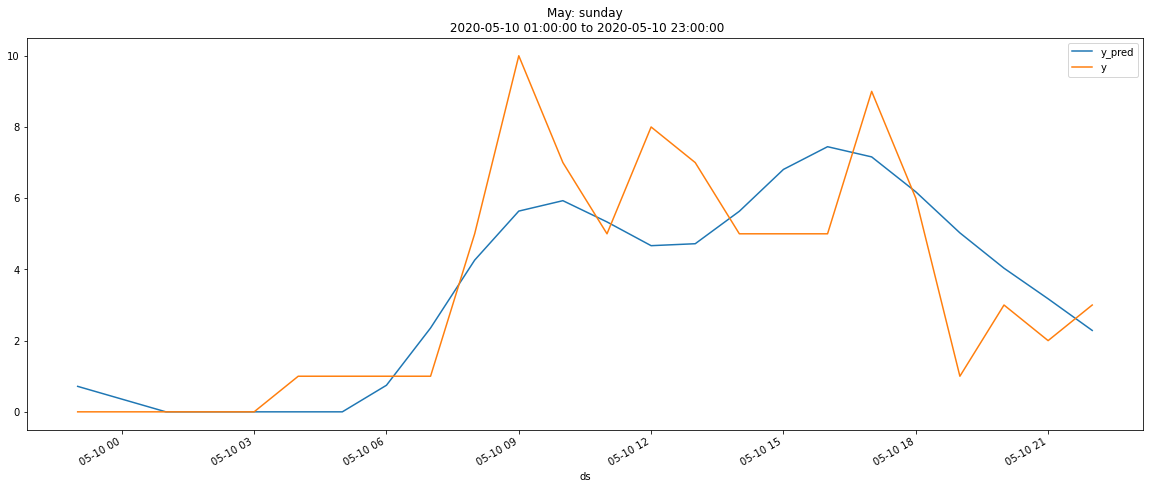

In [283]:
init_date = '2020-05-10 01:00:00'
end_date = '2020-05-10 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: sunday\n %s to %s'%(init_date, end_date))
plt.savefig("{}prophet_forecast_may2020_sunday10_g47_noscaled.png".format(PATH_IMG), format="png")